In [1]:
import torch
import kagglehub
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random

In [2]:
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
# Download latest version
path = kagglehub.dataset_download("agungpambudi/mnist-multiple-dataset-comprehensive-analysis")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-multiple-dataset-comprehensive-analysis


In [4]:
dataset_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"
count = 0

for root, dirs, files in os.walk(dataset_path):
    if count >= 10:
        break
    for file in files:
        if file.endswith(".png"):
            print("Rutas encontradas con las imagenes")
            print("-", os.path.join(root, file))
            count += 1
            if count >= 10:
                break

Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/428.0.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/41.7.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/654.5.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/604.7.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/740.0.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/188.3.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-comprehensive-analysis/PolyMNIST/MMNIST/test/m4/541.8.png
Rutas encontradas con las imagenes
- /kaggle/input/mnist-multiple-dataset-com

In [5]:
train_path = os.path.join(dataset_path, "PolyMNIST", "MMNIST", "train")
modalities = [d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))]
print("Modalidades encontradas:", modalities)

Modalidades encontradas: ['m4', 'm2', 'm0', 'm1', 'm3']


In [6]:
dataset_path = "/kaggle/input/mnist-multiple-dataset-comprehensive-analysis"
base_path = os.path.join(dataset_path, "PolyMNIST", "MMNIST")

data = []

for split in ["train", "test"]:
    split_path = os.path.join(base_path, split)
    if not os.path.exists(split_path):
        continue
    for modality in os.listdir(split_path):
        modality_path = os.path.join(split_path, modality)
        if not os.path.isdir(modality_path):
            continue
        for file in os.listdir(modality_path):
            if file.endswith(".png"):
                try:
                    label = int(file.split(".")[1])  # Ej: 1234.5.png → 5
                    full_path = os.path.join(modality_path, file)
                    data.append({
                        "file_path": full_path,
                        "label": label,
                        "modality": modality,
                        "split": split
                    })
                except Exception as e:
                    print(f"Error con archivo: {file} → {e}")

df = pd.DataFrame(data)
print("DataFrame generado con", len(df), "registros.")
print(df.head())

DataFrame generado con 350000 registros.
                                           file_path  label modality  split
0  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train
1  /kaggle/input/mnist-multiple-dataset-comprehen...      0       m4  train
2  /kaggle/input/mnist-multiple-dataset-comprehen...      0       m4  train
3  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train
4  /kaggle/input/mnist-multiple-dataset-comprehen...      9       m4  train


### Realización de 2 modelos CNN de distintas capas

In [7]:
class PolyMNISTDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'file_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

train_dataset = PolyMNISTDataset(train_df, transform)
test_dataset = PolyMNISTDataset(test_df, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28→14
        x = self.pool(F.relu(self.conv2(x)))  # 14→7
        x = x.view(-1, 32 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 28→14
        x = self.pool(F.relu(self.conv2(x)))  # 14→7
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [11]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [12]:
def train_model(model, train_loader, test_loader, epochs=5):
    print("Iniciando entrenamiento...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / total
        train_acc = 100 * correct / total

        test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)

        train_losses.append(avg_train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch}/{epochs} - "
              f"Train Loss: {avg_train_loss:.4f} - Train Acc: {train_acc:.2f}% - "
              f"Test Loss: {test_loss:.4f} - Test Acc: {test_acc:.2f}%")

    # Gráfica de pérdida
    plt.figure()
    plt.plot(train_losses, label='Pérdida en entrenamiento')
    plt.plot(test_losses, label='Pérdida en validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Pérdida durante el entrenamiento')
    plt.legend()
    plt.show()

    # Gráfica de accuracy
    plt.figure()
    plt.plot(train_accuracies, label='Accuracy en entrenamiento')
    plt.plot(test_accuracies, label='Accuracy en validación')
    plt.xlabel('Época')
    plt.ylabel('Accuracy')
    plt.title('Accuracy durante el entrenamiento')
    plt.legend()
    plt.show()

    return test_accuracies[-1]

Entrenamiento de Modelo SimpleCNN
Iniciando entrenamiento...
Epoch 1/5 - Train Loss: 0.1935 - Train Acc: 94.05% - Test Loss: 0.0947 - Test Acc: 96.92%
Epoch 2/5 - Train Loss: 0.0732 - Train Acc: 97.67% - Test Loss: 0.0801 - Test Acc: 97.42%
Epoch 3/5 - Train Loss: 0.0485 - Train Acc: 98.42% - Test Loss: 0.0757 - Test Acc: 97.73%
Epoch 4/5 - Train Loss: 0.0354 - Train Acc: 98.81% - Test Loss: 0.0772 - Test Acc: 97.79%
Epoch 5/5 - Train Loss: 0.0270 - Train Acc: 99.08% - Test Loss: 0.0818 - Test Acc: 97.85%


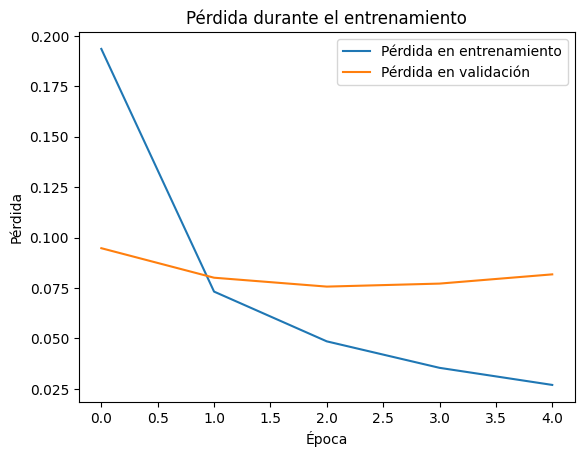

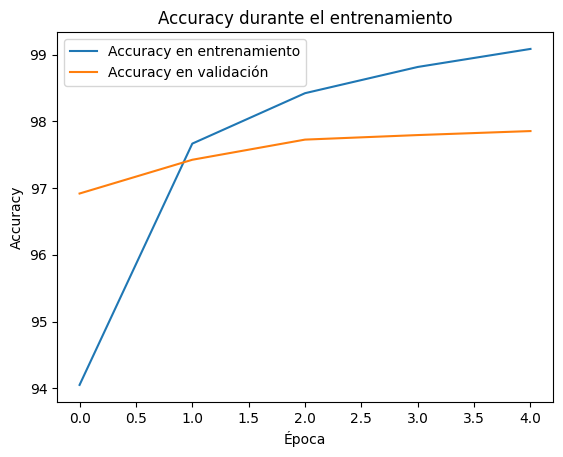

In [13]:
print("Entrenamiento de Modelo SimpleCNN")
model1 = SimpleCNN()
acc1 = train_model(model1, train_loader, test_loader, epochs=5)

Entrenamiento de Modelo DeepCNN
Iniciando entrenamiento...
Epoch 1/5 - Train Loss: 0.1617 - Train Acc: 94.95% - Test Loss: 0.0689 - Test Acc: 97.81%
Epoch 2/5 - Train Loss: 0.0657 - Train Acc: 97.88% - Test Loss: 0.0588 - Test Acc: 98.15%
Epoch 3/5 - Train Loss: 0.0448 - Train Acc: 98.55% - Test Loss: 0.0569 - Test Acc: 98.32%
Epoch 4/5 - Train Loss: 0.0356 - Train Acc: 98.83% - Test Loss: 0.0651 - Test Acc: 98.19%
Epoch 5/5 - Train Loss: 0.0305 - Train Acc: 98.99% - Test Loss: 0.0658 - Test Acc: 98.20%


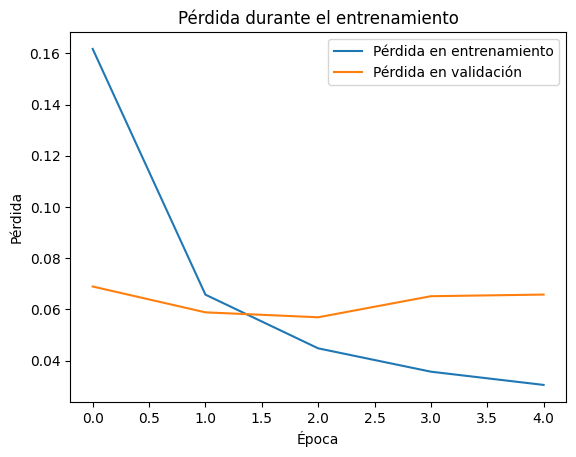

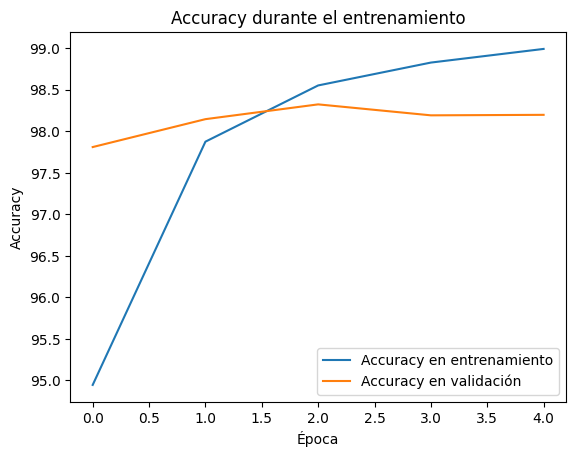

In [14]:
print("Entrenamiento de Modelo DeepCNN")
model2 = DeepCNN()
acc2 = train_model(model2, train_loader, test_loader, epochs=5)

In [15]:
if acc1 > acc2:
    print("Mejor modelo: SimpleCNN")
else:
    print("Mejor modelo: DeepCNN")

Mejor modelo: DeepCNN


In [20]:
def predict_random_image(model, dataset, class_names=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    idx = random.randint(0, len(dataset) - 1)
    image, label = dataset[idx]
    image_input = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_input)
        predicted = torch.argmax(output, 1).item()

    image_np = image.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * 0.5 + 0.5).clip(0, 1)

    plt.imshow(image_np)
    plt.title(f"Real: {label} | Predicho: {predicted}")
    plt.axis('off')
    plt.show()

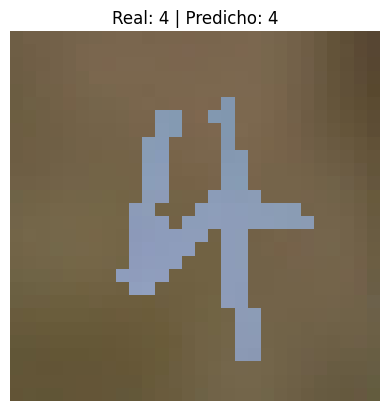

In [21]:
predict_random_image(model2, test_dataset)